In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import random
import torch.nn.functional as F

In [27]:
# Load the DataFrame
df = pd.read_csv("./data.csv") # Make sure your data.csv is in the correct path

# --- Data Preparation ---
# 1. Clean the 'toponym' column: convert to string, strip whitespace, convert to lowercase
df['toponym'] = df['toponym'].astype(str).str.strip().str.lower()

# 2. Convert each toponym string into a list of tokens, adding <S> and <E>
#    Each character will be a separate token
#    We create a new column 'toponym_tokens' to store these lists
df['toponym_tokens'] = df['toponym'].apply(lambda x: ['<S>'] + list(x) + ['<E>'])

# Get all unique tokens from your processed data
all_tokens = []
for tokens_list in df['toponym_tokens']:
    all_tokens.extend(tokens_list)

# Create a sorted list of unique tokens (your vocabulary)
vocab = sorted(list(set(all_tokens)))

In [ ]:
stoi = {token: i for i, token in enumerate(vocab)}

# Create mapping from integer to token (itos) for debugging/display
itos = {i: token for token, i in stoi.items()}

# Print the vocabulary size
vocab_size = len(vocab)
print(f"Vocabulary size: {vocab_size}")
print(f"stoi mapping: {stoi}")

Vocabulary size: 44
stoi mapping: {' ': 0, "'": 1, '-': 2, '<E>': 3, '<S>': 4, 'a': 5, 'b': 6, 'c': 7, 'd': 8, 'e': 9, 'f': 10, 'g': 11, 'h': 12, 'i': 13, 'j': 14, 'k': 15, 'l': 16, 'm': 17, 'n': 18, 'o': 19, 'p': 20, 'q': 21, 'r': 22, 's': 23, 't': 24, 'u': 25, 'v': 26, 'w': 27, 'x': 28, 'y': 29, 'z': 30, 'à': 31, 'â': 32, 'ç': 33, 'è': 34, 'é': 35, 'ê': 36, 'ë': 37, 'î': 38, 'ï': 39, 'ô': 40, 'û': 41, 'ü': 42, 'œ': 43}


In [29]:
# Define your context window size
block_size = 3 # Example: uses 3 previous characters to predict the next

# Initialize lists to store our input sequences (X) and target characters (Y)
X, Y = [], []

# Iterate through each preprocessed toponym (list of tokens)
for tokens_list in df['toponym_tokens']:
    # Pad the beginning of the context with the start-of-sequence token ID
    # This ensures every sequence has a full 'block_size' context, even at the start.
    context = [stoi['<S>']] * block_size

    # Iterate through each token in the current toponym, including <E>
    # The current 'token_id' will be our target (Y) for the current 'context' (X)
    for token_str in tokens_list:
        # Convert the current token to its integer ID
        token_id = stoi[token_str]

        # Add the current context (as a list of integers) to X
        X.append(context)

        # Add the current token's ID (which is the next character) to Y
        Y.append(token_id)

        # Update the context by sliding the window:
        # Remove the oldest character from the left and add the new character (token_id) to the right
        context = context[1:] + [token_id]

# Convert the Python lists to PyTorch tensors
X = torch.tensor(X)
Y = torch.tensor(Y)

print(f"\nShape of X (inputs): {X.shape}")
print(f"Shape of Y (targets): {Y.shape}")
print(f"Data type of X: {X.dtype}")
print(f"Data type of Y: {Y.dtype}")

# Example of the first few X and Y pairs
print("\nFirst 10 X, Y pairs:")
for i in range(20):
    context_chars = ''.join(itos[idx.item()] for idx in X[i])
    target_char = itos[Y[i].item()]
    print(f"Context: {context_chars} ---> Target: {target_char}")


Shape of X (inputs): torch.Size([98653, 3])
Shape of Y (targets): torch.Size([98653])
Data type of X: torch.int64
Data type of Y: torch.int64

First 10 X, Y pairs:
Context: <S><S><S> ---> Target: <S>
Context: <S><S><S> ---> Target: f
Context: <S><S>f ---> Target: r
Context: <S>fr ---> Target: a
Context: fra ---> Target: n
Context: ran ---> Target: c
Context: anc ---> Target: e
Context: nce ---> Target: <E>
Context: <S><S><S> ---> Target: <S>
Context: <S><S><S> ---> Target: f
Context: <S><S>f ---> Target: r
Context: <S>fr ---> Target: a
Context: fra ---> Target: n
Context: ran ---> Target: c
Context: anc ---> Target: e
Context: nce ---> Target:  
Context: ce  ---> Target: m
Context: e m ---> Target: é
Context:  mé ---> Target: t
Context: mét ---> Target: r


In [30]:
# Training split, dev/validation split, test split
# 80%, 10%, 10%

# Set a random seed for reproducibility in data splitting
random.seed(42) # Using random module for shuffling indices before splitting

# Create a permutation of indices
indices = list(range(X.shape[0]))
random.shuffle(indices)

n1 = int(0.8 * len(indices))
n2 = int(0.9 * len(indices))

Xtr, Ytr = X[indices[:n1]], Y[indices[:n1]]
Xdev, Ydev = X[indices[n1:n2]], Y[indices[n1:n2]]
Xte, Yte = X[indices[n2:]], Y[indices[n2:]]

print(f"\nXtr shape: {Xtr.shape}, Ytr shape: {Ytr.shape}")
print(f"Xdev shape: {Xdev.shape}, Ydev shape: {Ydev.shape}")
print(f"Xte shape: {Xte.shape}, Yte shape: {Yte.shape}")



Xtr shape: torch.Size([78922, 3]), Ytr shape: torch.Size([78922])
Xdev shape: torch.Size([9865, 3]), Ydev shape: torch.Size([9865])
Xte shape: torch.Size([9866, 3]), Yte shape: torch.Size([9866])


In [31]:
# Initialize PyTorch's random number generator for reproducibility
g = torch.Generator().manual_seed(2147483647)

# Embedding layer: maps each token ID to a 'd' dimensional vector
# Here, d = 10, so each character is represented by a 10-dimensional vector
emb_dim = 10
C = torch.randn((vocab_size, emb_dim), generator=g)

# First linear layer (hidden layer)
# Input features: block_size * emb_dim (e.g., 3 * 10 = 30)
# Output features: 200 (number of neurons in the hidden layer)
hidden_size = 200
W1 = torch.randn((block_size * emb_dim, hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)

# Second linear layer (output layer)
# Input features: hidden_size (200)
# Output features: vocab_size (number of possible next tokens)
W2 = torch.randn((hidden_size, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

# Combine all parameters into a list for easier management during training
parameters = [C, W1, b1, W2, b2]

# Set requires_grad to True for all parameters to enable gradient computation
for p in parameters:
    p.requires_grad = True

print(f"\nTotal number of parameters in the model: {sum(p.nelement() for p in parameters)}")



Total number of parameters in the model: 15484



Starting training for 200000 iterations...
Iteration 0/200000, Loss: 29.6854
Iteration 10000/200000, Loss: 2.0319
Iteration 20000/200000, Loss: 1.7992
Iteration 30000/200000, Loss: 1.8110
Iteration 40000/200000, Loss: 2.1597
Iteration 50000/200000, Loss: 1.8407
Iteration 60000/200000, Loss: 1.5836
Iteration 70000/200000, Loss: 1.9929
Iteration 80000/200000, Loss: 1.8040
Iteration 90000/200000, Loss: 1.7647
Iteration 100000/200000, Loss: 1.6412
Iteration 110000/200000, Loss: 1.5217
Iteration 120000/200000, Loss: 1.5071
Iteration 130000/200000, Loss: 1.6831
Iteration 140000/200000, Loss: 2.0323
Iteration 150000/200000, Loss: 1.6342
Iteration 160000/200000, Loss: 1.8259
Iteration 170000/200000, Loss: 1.8435
Iteration 180000/200000, Loss: 1.6631
Iteration 190000/200000, Loss: 1.7125
Training finished. Final training loss: 2.1421


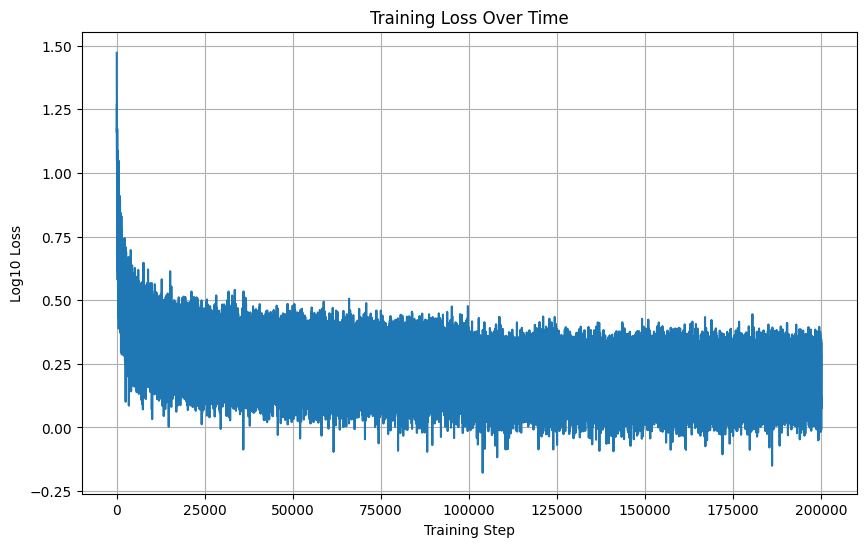

In [32]:
# --- Training Loop ---
lri = []      # To store learning rates
lossi = []    # To store training loss at each step
stepi = []    # To store step number

# Number of training iterations
num_iterations = 200000
batch_size = 32

print(f"\nStarting training for {num_iterations} iterations...")
for i in range(num_iterations):
    # Minibatch construct: randomly sample 'batch_size' examples from the training set
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))

    # Forward pass
    # 1. Embedding lookup: C[Xtr[ix]] transforms token IDs into their embeddings
    #    Shape: (batch_size, block_size, emb_dim)
    emb = C[Xtr[ix]]

    # 2. Reshape embeddings and pass through the first linear layer (hidden layer)
    #    emb.view(-1, block_size * emb_dim) flattens the block_size and emb_dim dimensions
    #    for each example in the batch.
    #    Shape after view: (batch_size, block_size * emb_dim)
    #    Shape after @ W1 + b1: (batch_size, hidden_size)
    h = torch.tanh(emb.view(-1, block_size * emb_dim) @ W1 + b1)

    # 3. Pass through the second linear layer (output layer) to get logits
    #    Shape: (batch_size, vocab_size)
    logits = h @ W2 + b2

    # 4. Calculate the loss using cross-entropy.
    #    F.cross_entropy automatically applies softmax and negative log likelihood.
    loss = F.cross_entropy(logits, Ytr[ix])

    # Backward pass
    # Zero out gradients before computing new ones
    for p in parameters:
        p.grad = None
    # Compute gradients of the loss with respect to parameters
    loss.backward()

    # Update parameters
    # The learning rate schedule: higher at the beginning, then decreases
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        # Update weights using gradient descent
        p.data += -lr * p.grad

    # Track stats
    stepi.append(i)
    lossi.append(loss.log10().item()) # Store log10 of the loss for better visualization

    if i % 10000 == 0:
        print(f"Iteration {i}/{num_iterations}, Loss: {loss.item():.4f}")

print(f"Training finished. Final training loss: {loss.item():.4f}")

# Plotting the training loss
plt.figure(figsize=(10, 6))
plt.plot(stepi, lossi)
plt.xlabel("Training Step")
plt.ylabel("Log10 Loss")
plt.title("Training Loss Over Time")
plt.grid(True)
plt.show()

In [33]:
# --- Model Evaluation ---

# Function to calculate loss on a dataset split
def evaluate_loss(X_data, Y_data, C, W1, b1, W2, b2, block_size):
    # Set model to evaluation mode (not strictly necessary for this simple model,
    # but good practice for models with dropout/batchnorm)
    for p in parameters:
        p.requires_grad = False # Turn off gradient computation during evaluation

    emb = C[X_data]
    h = torch.tanh(emb.view(-1, block_size * C.shape[1]) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Y_data)

    for p in parameters:
        p.requires_grad = True # Turn gradients back on for potential further training
    return loss.item()

train_loss = evaluate_loss(Xtr, Ytr, C, W1, b1, W2, b2, block_size)
dev_loss = evaluate_loss(Xdev, Ydev, C, W1, b1, W2, b2, block_size)
test_loss = evaluate_loss(Xte, Yte, C, W1, b1, W2, b2, block_size)

print(f"\n--- Evaluation ---")
print(f"Training Loss: {train_loss:.4f}")
print(f"Development (Validation) Loss: {dev_loss:.4f}")
print(f"Test Loss: {test_loss:.4f}")



--- Evaluation ---
Training Loss: 1.5944
Development (Validation) Loss: 1.7685
Test Loss: 1.7355


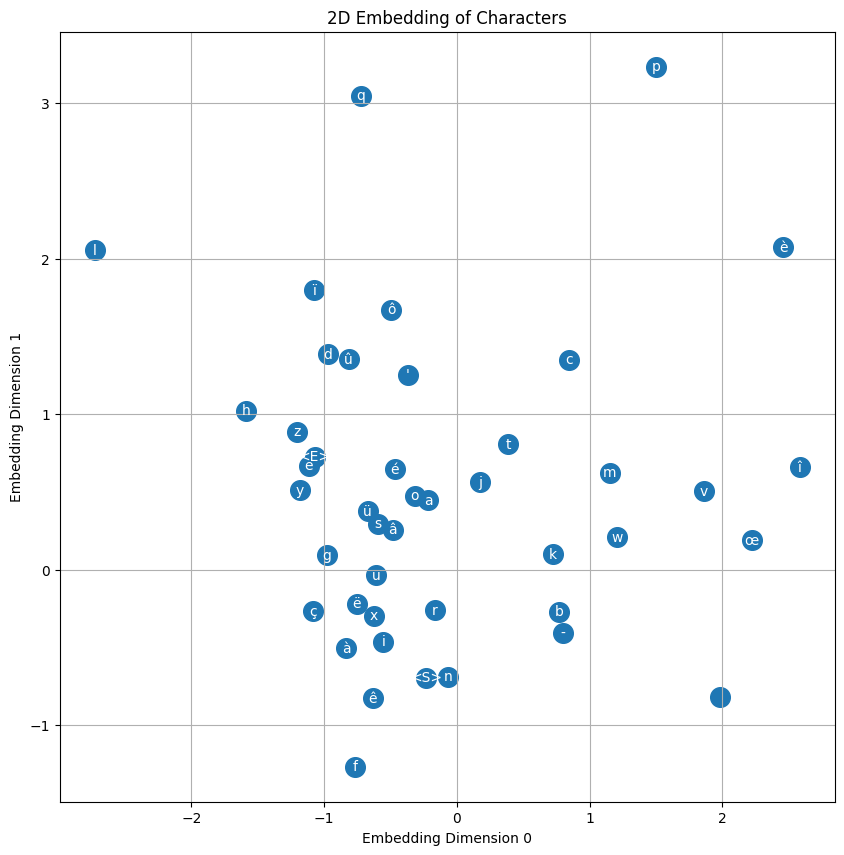

In [34]:
# --- Visualize dimensions 0 and 1 of the embedding matrix C for all characters ---
plt.figure(figsize=(10,10))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')
plt.title("2D Embedding of Characters")
plt.xlabel("Embedding Dimension 0")
plt.ylabel("Embedding Dimension 1")
plt.show()

In [36]:
# --- Sample from the model ---
print("\n--- Generating new toponyms ---")
g_sample = torch.Generator().manual_seed(2147483647 + 10) # Different seed for sampling

for _ in range(20): # Generate 20 toponyms
    out = []
    # Initialize context with start-of-sequence tokens
    context = [stoi['<S>']] * block_size
    while True:
        # Get embeddings for the current context
        emb = C[torch.tensor([context])] # Shape: (1, block_size, emb_dim)

        # Flatten the embeddings and pass through the hidden layer
        h = torch.tanh(emb.view(1, -1) @ W1 + b1) # Shape: (1, hidden_size)

        # Get logits for the next character
        logits = h @ W2 + b2 # Shape: (1, vocab_size)

        # Convert logits to probabilities using softmax
        probs = F.softmax(logits, dim=1)

        # Sample the next character from the probability distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g_sample).item()

        # Update the context by sliding the window
        context = context[1:] + [ix]

        # Stop if the end-of-sequence token is generated
        if ix == stoi['<E>']:
            break # Exit the loop, don't append <E>

        # Append the sampled character to the output list ONLY if it's not <S> or <E>
        # We also need to handle the case where the model might predict an <S> itself.
        # It's usually better to just append all predicted chars and clean at the end.
        out.append(ix)

    # Decode and print the generated toponym
    # Filter out <S> and <E> tokens before joining
    final_toponym_chars = []
    for token_id in out:
        if itos[token_id] not in ['<S>', '<E>']: # Exclude <S> and <E> from the final string
            final_toponym_chars.append(itos[token_id])

    print(''.join(final_toponym_chars))


--- Generating new toponyms ---
peyrel
montours
champagnère
bas
maint-tcolins-la-primiranche-bylanquie-lès-tourneille
yvelles
esle
chal
med
sallan-de-les
rauent du voie
touly
houties
lynésères
mazet
juen-verneuf
vergent de la boupe
saine-sainvilla
ignac-et-la-villong-sur-sèvres
veur
